In [3]:
!pip install kaggle
!echo '{"username":"YOURUSERNAME","key":"YOURAPIKEY"}' > kaggle.json #Add user name and api auth key
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c cs-480-2024-spring
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/196207162.jpeg  
  inflating: data/train_images/196207164.jpeg  
  inflating: data/train_images/196207198.jpeg  
  inflating: data/train_images/196207403.jpeg  
  inflating: data/train_images/196207539.jpeg  
  inflating: data/train_images/196207572.jpeg  
  inflating: data/train_images/196207729.jpeg  
  inflating: data/train_images/196207888.jpeg  
  inflating: data/train_images/196208355.jpeg  
  inflating: data/train_images/196208682.jpeg  
  inflating: data/train_images/196208848.jpeg  
  inflating: data/train_images/196209074.jpeg  
  inflating: data/train_images/196209078.jpeg  
  inflating: data/train_images/196209236.jpeg  
  inflating: data/train_images/196209887.jpeg  
  inflating: data/train_images/196209889.jpeg  
  inflating: data/train_images/196209960.jpeg  
  inflating: data/train_images/196210323.jpeg  
  inflating: data/train_images/196211220.jpeg  
  inflating: data/train_images/196211

In [4]:
#Parameters

test_size = 0.2 #train-val split
random_state = 42 #seed for split
learning_rate = 1e-4 #learning
batch_size = 32
epochs = 20
weight_decay = 1e-4 #l2 regularizer strength
dropout_rate = 0.2

In [5]:
#Data preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input



#Read train data
train_data = pd.read_csv('data/train.csv')
train_data = train_data.sort_values(by='id')

#Read test data
test_data = pd.read_csv('data/test.csv')
test_data = test_data.sort_values(by='id')



def preprocess_images(image_directory):
    images = []
    image_ids = []

    # Get a sorted list of image filenames
    sorted_img_names = sorted(os.listdir(image_directory), key=lambda x: int(x.split('.')[0]))
    print(sorted_img_names)

    for img_name in sorted_img_names:
        img_path = os.path.join(image_directory, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        image_ids.append(img_name.split('.')[0])  # Extract ID from filename

    images = np.array(images)
    return images, image_ids

# Preprocess and sort images by IDs
train_images, train_image_ids = preprocess_images('data/train_images')
test_images, test_image_ids = preprocess_images('data/test_images')

print("Shape of train_images:", train_images.shape)
print("Shape of test_images:", test_images.shape)

# Split the training data into training and validation sets

targets = train_data[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']].values
train_images_train, train_images_val,targets_train, targets_val, ancillary_train,ancillary_val = train_test_split(
    train_images,
    targets,
    train_data.iloc[:, 1:164],  # Select all anicllary columns except 'id'
    test_size=test_size,
    random_state=random_state
)

#Normalize ancillary data for training, testing and validation
scaler_ancillary = MinMaxScaler()
ancillary_train = scaler_ancillary.fit_transform(ancillary_train)
ancillary_val = scaler_ancillary.transform(ancillary_val)
test_data_ancillary = test_data.iloc[:, 1:164]
test_data.iloc[:,1:164] = scaler_ancillary.transform(test_data_ancillary)

#normalize the target values for training and validation
scaler_target = MinMaxScaler()
targets_train = np.log10(targets_train + 1e-6)
targets_val = np.log10(targets_val + 1e-6)
targets_train = scaler_target.fit_transform(targets_train)
targets_val = scaler_target.transform(targets_val)


['26375.jpeg', '59175.jpeg', '79969.jpeg', '385693.jpeg', '453196.jpeg', '561122.jpeg', '574174.jpeg', '577662.jpeg', '608516.jpeg', '608517.jpeg', '639554.jpeg', '648966.jpeg', '993123.jpeg', '994535.jpeg', '998892.jpeg', '1040341.jpeg', '1040499.jpeg', '1042196.jpeg', '1042255.jpeg', '1042260.jpeg', '1042278.jpeg', '1042296.jpeg', '1042297.jpeg', '1043827.jpeg', '1043830.jpeg', '1175011.jpeg', '1219465.jpeg', '1298728.jpeg', '1341906.jpeg', '1350791.jpeg', '1381645.jpeg', '1381705.jpeg', '1410135.jpeg', '1691847.jpeg', '1707991.jpeg', '1727892.jpeg', '1727909.jpeg', '1737764.jpeg', '1789642.jpeg', '1817170.jpeg', '1817177.jpeg', '1836850.jpeg', '1908025.jpeg', '1909633.jpeg', '1917486.jpeg', '1935871.jpeg', '2085858.jpeg', '2308417.jpeg', '2315120.jpeg', '2374441.jpeg', '2452454.jpeg', '2462714.jpeg', '2462778.jpeg', '2482991.jpeg', '2484996.jpeg', '2485078.jpeg', '2491256.jpeg', '2491302.jpeg', '2491358.jpeg', '2574508.jpeg', '2656174.jpeg', '2679644.jpeg', '2734951.jpeg', '2742694.

In [6]:
##CNN Model with res net

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

image_input = layers.Input(shape=(128,128,3))
ancillary_input = layers.Input(shape=(163,))

vgg_net = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Freeze first 7 Layers
for layer in vgg_net.layers[:7]:
    layer.trainable = False
for layer in vgg_net.layers[7:]:
    layer.trainable = True

vgg_net_output = vgg_net(image_input)

# Global Average Pooling
vgg_net_output = layers.GlobalAveragePooling2D()(vgg_net_output)
cnn_output = vgg_net_output

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
#Layers for ancillary data

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(ancillary_input)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True #keras is a pain lol -- batch normalization needs explcit trainable param (refer to keras api)
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)




In [8]:
#This is the combined layer which takes input as the CNN output and the ancillary data output
combined = layers.concatenate([cnn_output, x])
# Dense layers with batch normalization and dropout
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(combined)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(128,activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(64,activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(32,activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
# x = layers.BatchNormalization()(x, training=True)
# x.trainable = True
x = layers.Dropout(dropout_rate)(x, training=True)
x.trainable = True
x = layers.Dense(16,activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay))(x)

# Output layer
output = layers.Dense(6, activation='linear')(x,training=True)
output.trainable = True
model = models.Model(inputs=[image_input, ancillary_input], outputs=output)




In [9]:
#Determine learning rate, optimizer and compile the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score


def r2_score_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

def average_loss(y_true, y_pred):
    # Calculate the MSE for each target variable
    mse_1 = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))
    mse_2 = K.mean(K.square(y_true[:, 1] - y_pred[:, 1]))
    mse_3 = K.mean(K.square(y_true[:, 2] - y_pred[:, 2]))
    mse_4 = K.mean(K.square(y_true[:, 3] - y_pred[:, 3]))
    mse_5 = K.mean(K.square(y_true[:, 4] - y_pred[:, 4]))
    mse_6 = K.mean(K.square(y_true[:, 5] - y_pred[:, 5]))

    # Calculate the average of the MSEs
    average_mse = (mse_1 + mse_2 + mse_3 + mse_4 + mse_5 + mse_6) / 6.0

    return average_mse

lr_reducer = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
optimizer = Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse',r2_score_metric])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 163)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         20,992 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 544)            │              0 │ global_average_poolin… │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        139,520 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_6[0][0]          │
├──────────────────────

 Total params: 14,929,398 (56.95 MB)

 Trainable params: 14,669,238 (55.96 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Epoch 1/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 166s 135ms/step - loss: 0.3204 - mse: 0.2332 - r2_score_metric: -1.4748 - val_loss: 0.0971 - val_mse: 0.0243 - val_r2_score_metric: 0.7422 - learning_rate: 1.0000e-04
Epoch 2/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 134s 124ms/step - loss: 0.1024 - mse: 0.0329 - r2_score_metric: 0.6494 - val_loss: 0.0836 - val_mse: 0.0226 - val_r2_score_metric: 0.7598 - learning_rate: 1.0000e-04
Epoch 3/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - loss: 0.0844 - mse: 0.0260 - r2_score_metric: 0.7230 - val_loss: 0.0722 - val_mse: 0.0211 - val_r2_score_metric: 0.7758 - learning_rate: 1.0000e-04
Epoch 4/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - loss: 0.0720 - mse: 0.0233 - r2_score_metric: 0.7518 - val_loss: 0.0615 - val_mse: 0.0194 - val_r2_score_metric: 0.7948 - learning_rate: 1.0000e-04
Epoch 5/20
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 135s 124ms/step - loss: 0.0614 - mse: 0.0213 - r2_score_metric: 0.7738 - val_loss: 0.0531 - val_mse: 0.0188 - val_r2_score_me

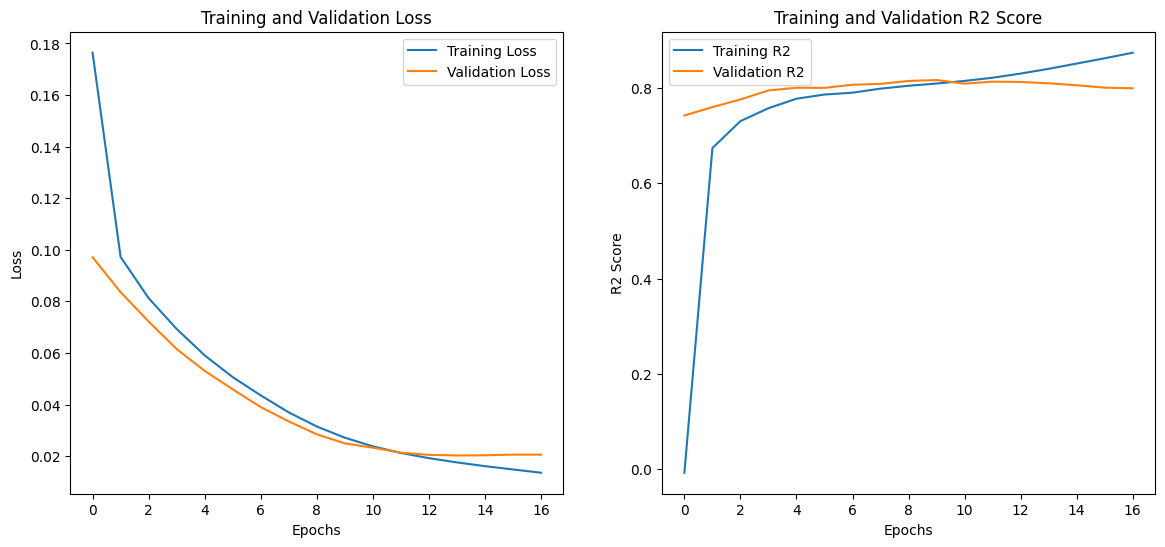

In [10]:

import matplotlib.pyplot as plt

#Train the model
history = model.fit(
    [train_images_train, ancillary_train],
    targets_train,
    validation_data=([train_images_val, ancillary_val], targets_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)


# Plot training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation R2 score
plt.subplot(1, 2, 2)
plt.plot(history.history['r2_score_metric'], label='Training R2')
plt.plot(history.history['val_r2_score_metric'], label='Validation R2')
plt.title('Training and Validation R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()

plt.show()


In [11]:
from sklearn.metrics import r2_score
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

#Predict on training and validation and get R2 score
y_pred_train = model.predict([train_images_train, ancillary_train])
r2_train = r2_score(targets_train, y_pred_train)
print(f"R2 Score on Training Set in Inference Mode: {r2_train:.4f}")

y_pred_val = model.predict([train_images_val, ancillary_val])
r2_val = r2_score(targets_val, y_pred_val)
print(f"R2 Score on Validation Set in Inference Mode: {r2_val:.4f}")

#Test

# Make predictions on the test data
test_data2 = test_data.iloc[:, 1:164]

predictions_normalized = model.predict([test_images, test_data2])

#Inverse transform the predictions to get them back to the original scale
predictions = scaler_target.inverse_transform(predictions_normalized)
predictions = np.power(10, predictions) - 1e-6
test_data2.head()

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step
R2 Score on Training Set in Inference Mode: 0.3472
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step
R2 Score on Validation Set in Inference Mode: 0.1485
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step


,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m03,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12
2135,0.904563,0.029205,0.037620,0.926001,0.111959,0.215122,0.911111,0.743056,0.814815,0.770370,...,0.172998,0.172498,0.181526,0.165445,0.148879,0.147890,0.171547,0.178246,0.174169,0.185890
6030,0.877405,0.120261,0.077304,0.508707,0.129045,0.215082,0.703704,0.631944,0.666667,0.666667,...,0.731118,0.750081,0.764100,0.721355,0.659110,0.591804,0.545153,0.520348,0.506854,0.607046
4813,0.619236,0.273254,0.183551,0.505354,0.222317,0.189035,0.525926,0.520833,0.466667,0.488889,...,0.783293,0.766232,0.782708,0.724644,0.696438,0.739142,0.809427,0.833099,0.803690,0.831614
4592,0.877405,0.120261,0.077304,0.508707,0.129045,0.215082,0.703704,0.631944,0.666667,0.666667,...,0.731118,0.750081,0.764100,0.721355,0.659110,0.591804,0.545153,0.520348,0.506854,0.607046
3104,0.797106,0.110898,0.081354,0.436282,0.285797,0.365366,0.762963,0.729167,0.777778,0.755556,...,0.636106,0.611615,0.612825,0.588300,0.558386,0.560983,0.594548,0.638513,0.632935,0.655392


In [12]:
loss_train = model.evaluate([train_images_train, ancillary_train], targets_train, verbose=0)
print(f"Loss on Training Set: {loss_train}")

loss_val = model.evaluate([train_images_val, ancillary_val], targets_val, verbose=0)
print(f"Loss on Validation Set: {loss_val}")

Loss on Training Set: [0.015381292439997196, 0.013060839846730232, 0.8610002994537354]
Loss on Validation Set: [0.020244590938091278, 0.017924152314662933, 0.8097614645957947]


In [13]:



submission = pd.DataFrame({
    'id': test_image_ids,
    'X4': predictions[:, 0],
    'X11': predictions[:, 1],
    'X18': predictions[:, 2],
    'X26': predictions[:, 3],
    'X50': predictions[:, 4],
    'X3112': predictions[:, 5]
})

# Save the submission file
submission.to_csv('submission.csv', index=False)


In [14]:
!kaggle competitions submit -c cs-480-2024-spring -f submission.csv -m "Message"

100% 430k/430k [00:01<00:00, 229kB/s]
Successfully submitted to CS480_2024_Spring